# Import Required Libraries
This section imports all necessary Python libraries for data analysis and visualization, such as pandas, numpy, and matplotlib.

In [4]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load Experiment Results
Load the results data from 'results/.../combined_data.csv' into a pandas DataFrame.

In [ ]:
# Load experiment results
data_path = '../results/template_experiment_2025-06-19_11-52-58/combined_data.csv'
df = pd.read_csv(data_path)
df

,codec,crf,resolution,video_name,preset,bitrate_kbps,vmaf,cpu_time_seconds
0,libx264,10,1080p,Debugging_1080p,ultrafast,4498.177,97.022590,1.91
1,libx264,10,1080p,Debugging_1080p,superfast,4373.695,97.235704,2.96
2,libx264,21,1080p,Debugging_1080p,ultrafast,3310.615,95.985765,1.87
3,libx264,21,1080p,Debugging_1080p,superfast,2839.403,96.164350,2.71
4,libx264,51,1080p,Debugging_1080p,ultrafast,1940.292,88.889491,1.85
5,libx264,51,1080p,Debugging_1080p,superfast,1843.419,88.666014,2.69
6,libx265,22,1080p,Debugging_1080p,ultrafast,3371.411,93.660319,6.64
7,libx265,22,1080p,Debugging_1080p,superfast,2384.697,94.660614,8.95
8,libx265,28,1080p,Debugging_1080p,ultrafast,2029.020,88.882195,6.54
9,libx265,28,1080p,Debugging_1080p,superfast,1500.509,91.069653,9.17


# Visualization: Rate-Distortion (RD) Curve
This section visualizes the Rate-Distortion curve (e.g., VMAF vs. Bitrate) for different videos, codecs and presets.

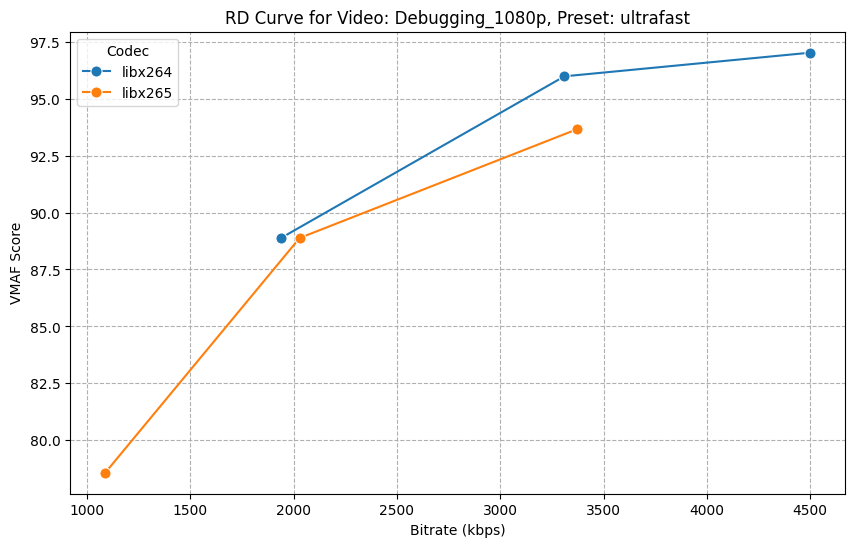

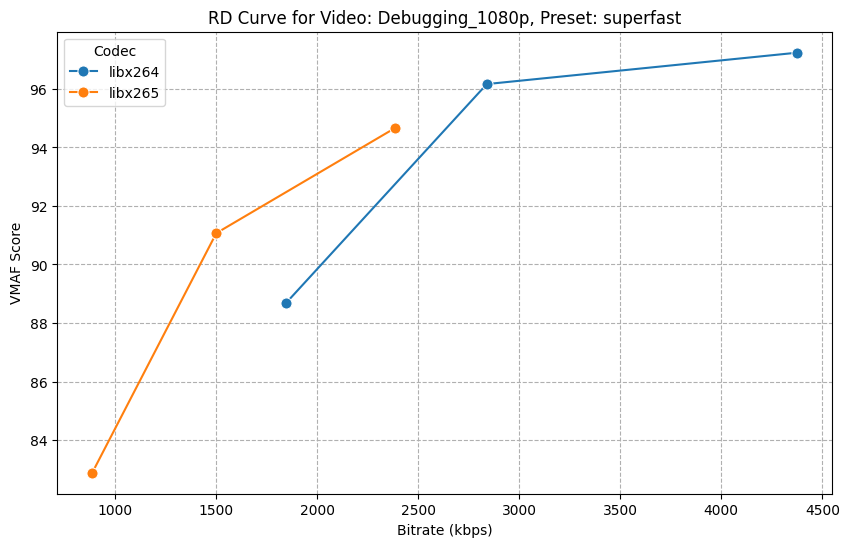

In [6]:
# Plot RD curves for each video_name and preset, showing all codecs
if 'video_name' in df.columns and 'preset' in df.columns:
    for video in df['video_name'].unique():
        for preset in df['preset'].unique():
            subset = df[(df['video_name'] == video) & (df['preset'] == preset)]
            plt.figure(figsize=(10, 6))
            sns.lineplot(
                data=subset,
                x='bitrate_kbps',
                y='vmaf',
                hue='codec',
                marker='o',
                markersize=8
            )
            plt.title(f'RD Curve for Video: {video}, Preset: {preset}')
            plt.xlabel('Bitrate (kbps)')
            plt.ylabel('VMAF Score')
            plt.legend(title='Codec')
            plt.grid(True, which='both', linestyle='--')
            plt.show()
else:
    print("The DataFrame must contain 'video_name' and 'preset' columns.")

# Visualization: Load and Display BD-Rate Results

In [11]:
import pandas as pd
import os

# Construct the path to the BD-Rate results CSV
# It should be in the same directory as the main combined_data.csv
bd_rate_path = data_path.replace('combined_data.csv', 'bd_rate_results.csv')

if os.path.exists(bd_rate_path):
    print(f"--- BD-Rate Results (from {os.path.basename(bd_rate_path)}) ---")
    bd_rate_df = pd.read_csv(bd_rate_path)
    
    # Optional: Display the results in a more readable format
    for (video, preset), group in bd_rate_df.groupby(['video_name', 'preset']):
        print(f"\nComparison for Video: '{video}', Preset: '{preset}'")
        print(group[['anchor_codec', 'test_codec', 'bd_rate_vmaf_%']].to_string(index=False))

    print("\n---------------------------------------------------")
    # You can also just display the raw DataFrame
    # display(bd_rate_df)
    
else:
    print(f"BD-Rate results file not found at: {bd_rate_path}")
    print("Please ensure results_processing.py has been run and generated the file.")

--- BD-Rate Results (from bd_rate_results.csv) ---

Comparison for Video: 'Debugging_1080p', Preset: 'superfast'
anchor_codec test_codec  bd_rate_vmaf_%
     libx264    libx265      -18.639473
     libx265    libx264       22.909725

Comparison for Video: 'Debugging_1080p', Preset: 'ultrafast'
anchor_codec test_codec  bd_rate_vmaf_%
     libx264    libx265       21.764055
     libx265    libx264      -17.873957

---------------------------------------------------


# Visualization: Speed vs. Efficiency Trade-off

 A Single Anchor Codec is Chosen, then the BD-Rate for a specific test point, for example, libx265 at the superfast preset, is calculated against the anchor codec at the corresponding superfast preset.

Plot saved to 'speed_vs_efficiency_plot.png'


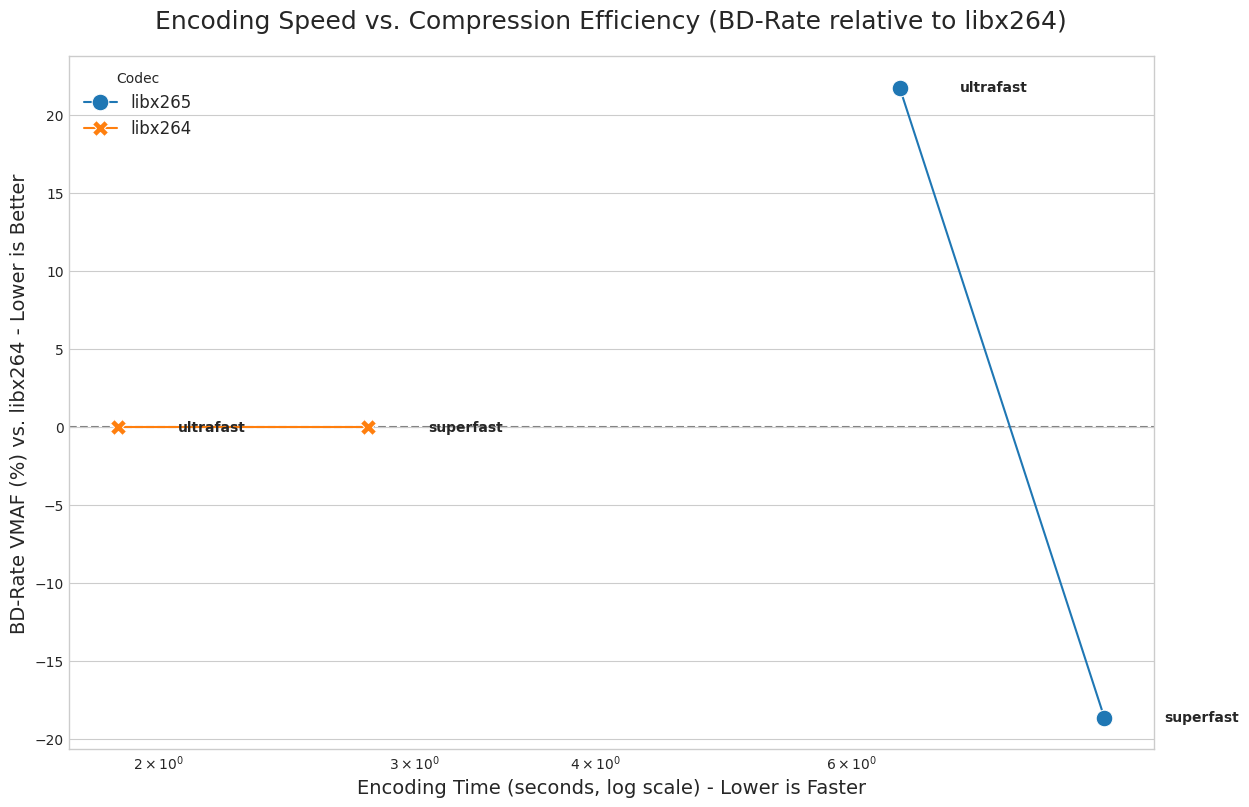

In [ ]:

# This cell creates a scatter plot to visualize the trade-off between
# encoding time (speed) and compression efficiency (BD-Rate).

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Define the anchor codec for comparison
ANCHOR_CODEC = 'libx264'

# Construct the path to the BD-Rate results CSV
# Assumes 'bd_rate_results.csv' is in the same folder as 'combined_data.csv'
bd_rate_path = data_path.replace('combined_data.csv', 'bd_rate_results.csv')

# Check that the required data files exist before proceeding
if not os.path.exists(data_path) or not os.path.exists(bd_rate_path):
    print(f"Error: Data files not found. Please run the experiment and results processing first.")
    print(f"Looked for: {data_path} and {bd_rate_path}")
else:
    # --- Data Preparation ---
    df_bd_rate = pd.read_csv(bd_rate_path)

    # Calculate the average encoding time for each codec and preset from the main dataframe 'df'
    df_time = df.groupby(['codec', 'preset'])['cpu_time_seconds'].mean().reset_index()

    # Filter BD-rate results to compare everything against the chosen anchor
    df_bd_rate_filtered = df_bd_rate[df_bd_rate['anchor_codec'] == ANCHOR_CODEC].copy()
    
    # Calculate the average BD-rate for each test codec and preset (averaging across different videos)
    df_bd_rate_avg = df_bd_rate_filtered.groupby(['test_codec', 'preset'])['bd_rate_vmaf_%'].mean().reset_index()
    df_bd_rate_avg.rename(columns={'test_codec': 'codec'}, inplace=True)

    # Merge the time and BD-rate data
    df_plot = pd.merge(df_time, df_bd_rate_avg, on=['codec', 'preset'])

    # Add the anchor codec's data (BD-Rate is 0 against itself)
    anchor_time_data = df_time[df_time['codec'] == ANCHOR_CODEC].copy()
    anchor_time_data['bd_rate_vmaf_%'] = 0.0

    # Combine into the final DataFrame for plotting
    df_plot = pd.concat([df_plot, anchor_time_data], ignore_index=True)

    # --- Plot Generation ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(14, 9))

    # Create the line/scatter plot
    sns.lineplot(
        data=df_plot,
        x='cpu_time_seconds',
        y='bd_rate_vmaf_%',
        hue='codec',
        style='codec',
        markers=True,
        markersize=12,
        dashes=False,
        ax=ax
    )

    # Set the x-axis to a logarithmic scale for better visualization
    ax.set_xscale('log')

    # Add labels for each data point (preset name)
    for idx, row in df_plot.iterrows():
        ax.text(row['cpu_time_seconds'] * 1.1, row['bd_rate_vmaf_%'], row['preset'], 
                fontsize=10, va='center', fontweight='bold')

    # Add a horizontal reference line at y=0
    ax.axhline(0, ls='--', color='gray', zorder=0)

    # --- Final Touches ---
    ax.set_title(f'Encoding Speed vs. Compression Efficiency (BD-Rate relative to {ANCHOR_CODEC})', fontsize=18, pad=20)
    ax.set_xlabel('Encoding Time (seconds, log scale) - Lower is Faster', fontsize=14)
    ax.set_ylabel(f'BD-Rate VMAF (%) vs. {ANCHOR_CODEC} - Lower is Better', fontsize=14)
    ax.legend(title='Codec', fontsize=12)
    
    # Save the figure to a file
    # The output path is relative to the notebook's location
    output_figure_path = 'speed_vs_efficiency_plot.png'
    plt.savefig(output_figure_path)
    print(f"Plot saved to '{output_figure_path}'")
    
    plt.show()